In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('seaborn')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18196\2851211882.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
data = pd.read_csv("data/adult.csv")
data.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

In [3]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


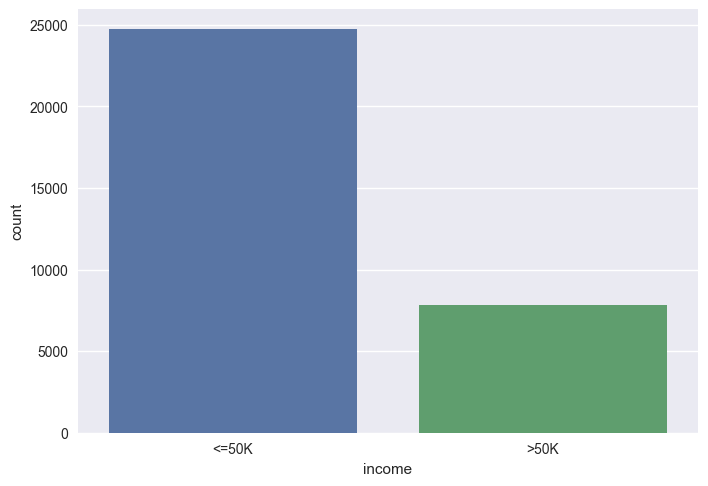

In [5]:
sns.countplot(data=data, x='income');

In [6]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [7]:
types = data.dtypes
cat_features = list(types[(types == "object")].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

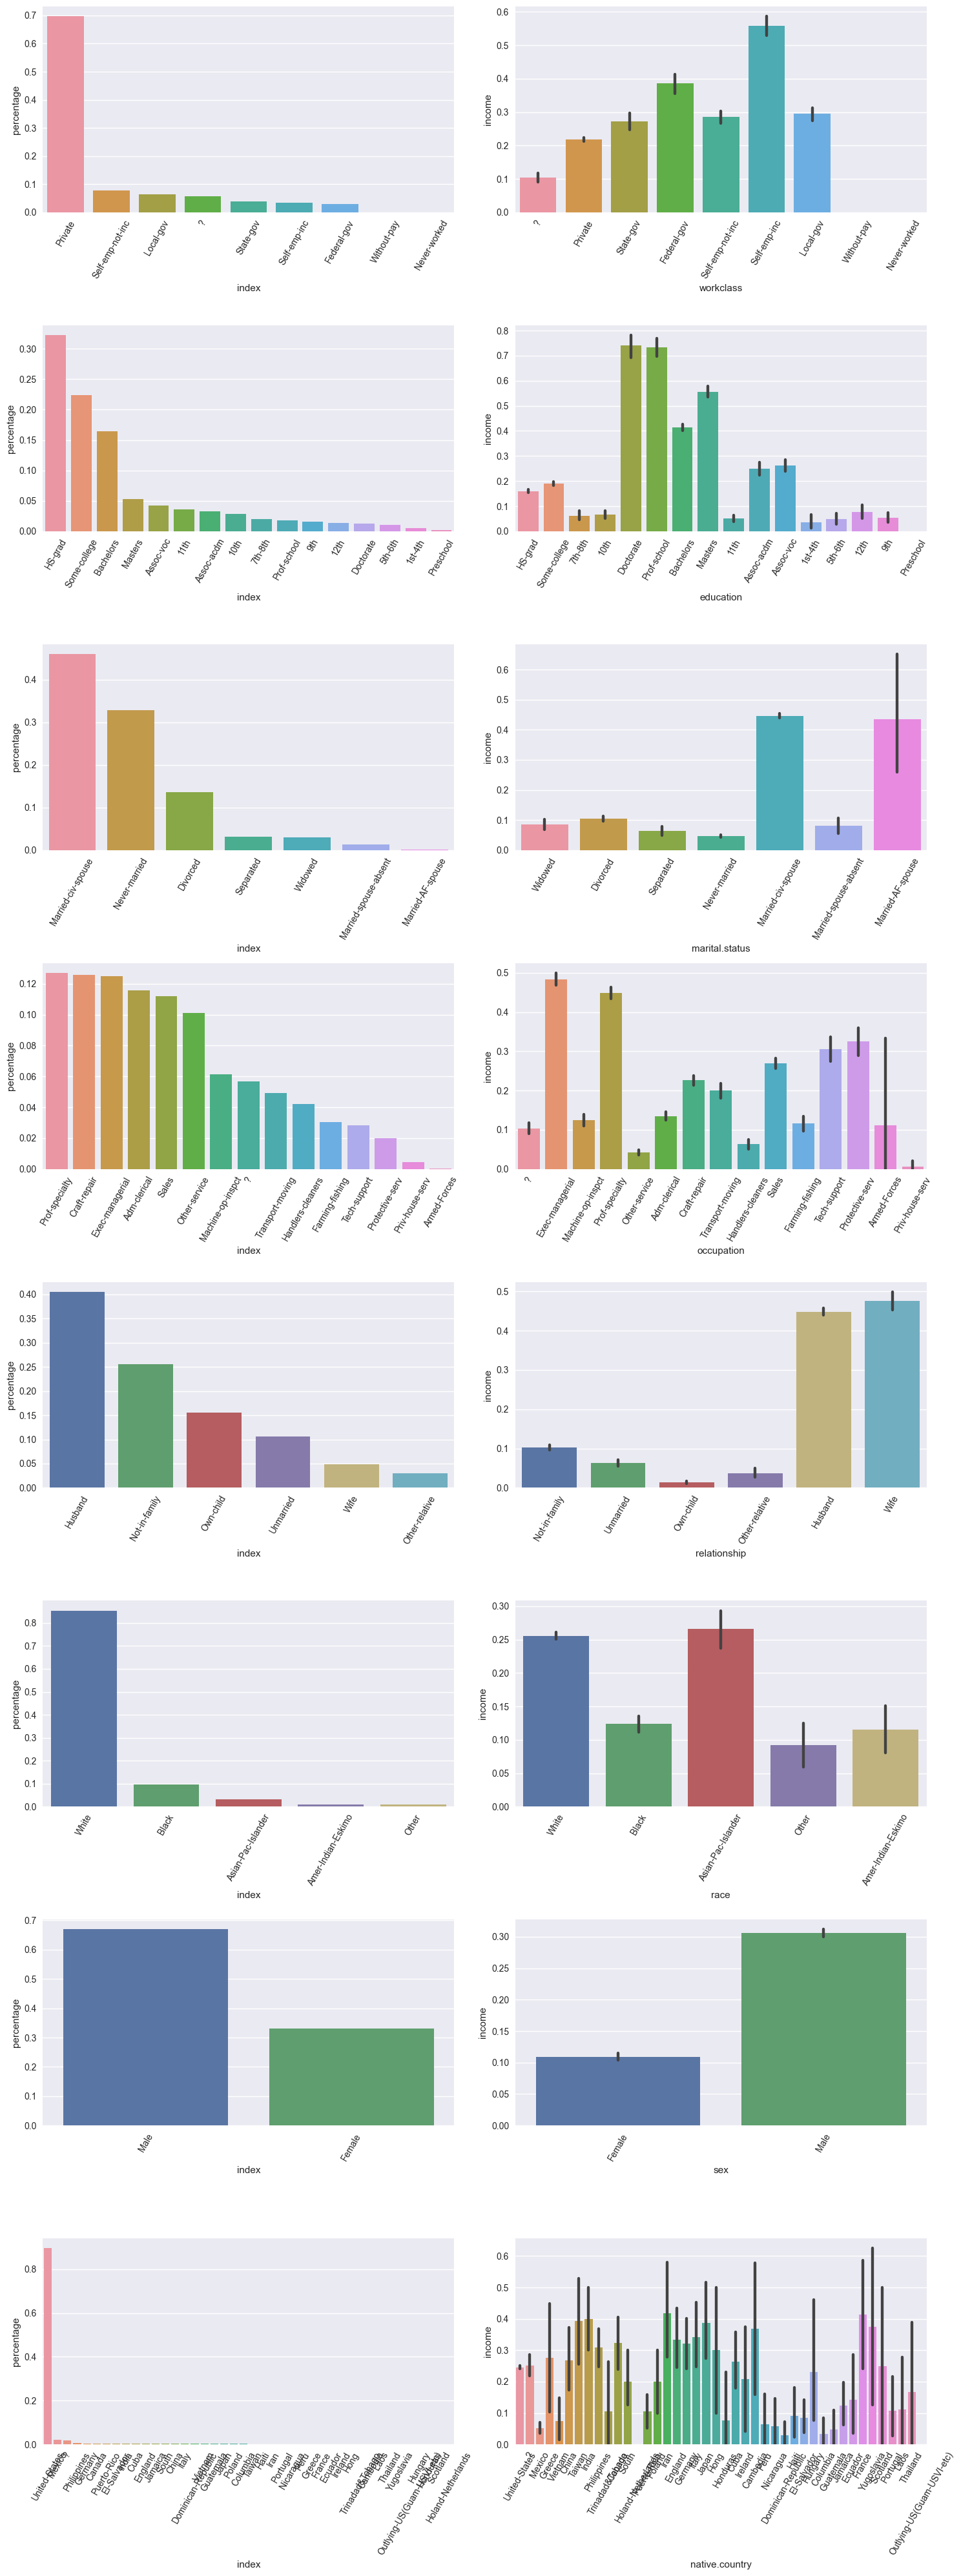

In [8]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

In [9]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

предобрабатываем числовые признаки

In [10]:
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#создаем новый признак разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [11]:
#удаляем ненужные признаки 
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'],axis=1)

In [12]:
adult_data.describe(include="object")

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


In [13]:
import plotly
import plotly.express as px
fig1 = px.imshow(
    adult_data.corr(),
    title='мультиколинеарность и взаимосвязь с целевым признаком',
    height=800,
    width=1000,
    text_auto=True
)
fig1.show()

In [14]:
dummies_data = pd.get_dummies(adult_data,drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


In [15]:
#сохдаем матрицу наблюдений X и векторов Y
X = dummies_data.drop(['income'],axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=1,test_size=0.2)

In [17]:
#производим нормализацию данных с помощью min_max нормализации

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Логистическая регресия

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [18]:
log_reg = linear_model.LogisticRegression(max_iter=1000)
#обучаем модель ,минимизирую logloss
log_reg.fit(X_train_scaled,y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64


### <center> **GridSearchCV**

Чтобы воспользоваться классом GridSearchCV:
- сначала необходимо импортировать библиотеку; 
- затем указать искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров; 
- после передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, (допустим, пятиблочную кросс-валидацию, cv=5) и n_jobs = -1, чтобы использовать все доступные ядра для расчетов.

Созданный нами объект grid_search аналогичен классификатору, мы можем вызвать стандартные методы fit, predict и score от его имени. Однако, когда мы вызываем fit, он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid.

GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



CPU times: total: 609 ms
Wall time: 53.5 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'lbfgs'}


In [23]:
parm_grid = [
            {"penalty":['12',"none"],
            "solver":["lbfgs","sag"],
            "C":[00.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
            {'penalty': ['l1', 'l2'] ,
            'solver': ['liblinear', 'saga'],
            'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state=1,max_iter=100),
    param_grid=param_grid,
    cv=5,
    n_jobs= -1
)
%time grid_search_1.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test_scaled, y_test)))
y_test_pred = grid_search_1.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



CPU times: total: 609 ms
Wall time: 15.1 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'penalty': 'none', 'solver': 'saga'}


c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

